Original notebook in my drive: https://colab.research.google.com/drive/1F99hX8ce-Q15G4-KJWQm51OB167JWMDx <br>
Submodules needed:
- 'https://github.com/NVIDIA/tacotron2.git'
- 'https://github.com/SortAnon/hifi-gan'

HIFIGAN_ID for hifimodel = "https://drive.google.com/uc?id=1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW"

In [1]:
graph_width = 900
graph_height = 360
sampling_rate = 22050
git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
git_hifi_gan_url = 'https://github.com/SortAnon/hifi-gan'

TACOTRON2_ID = '1F99hX8ce-Q15G4-KJWQm51OB167JWMDx'
HIFIGAN_ID = "1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW"

In [2]:
def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
            %matplotlib inline
            fig, axes = plt.subplots(1, len(data), figsize=figsize)
            for i in range(len(data)):
                axes[i].imshow(data[i], aspect='auto', origin='lower', 
                            interpolation='none', cmap='inferno')
            fig.canvas.draw()
            plt.show()
            
def ARPA(text, punctuation=r"!?,.;", EOS_Token=True):
            out = ''
            for word_ in text.split(" "):
                word=word_; end_chars = ''
                while any(elem in word for elem in punctuation) and len(word) > 1:
                    if word[-1] in punctuation: end_chars = word[-1] + end_chars; word = word[:-1]
                    else: break
                try:
                    word_arpa = thisdict[word.upper()]
                    word = "{" + str(word_arpa) + "}"
                except KeyError: pass
                out = (out + " " + word + end_chars).strip()
            if EOS_Token and out[-1] != ";": out += ";"
            return out

def get_hifigan(MODEL_ID):
    # Download HiFi-GAN
    hifigan_pretrained_model = 'hifimodel'
    if not exists(hifigan_pretrained_model):
        raise Exception("HiFI-GAN model is not found!")
    # Load HiFi-GAN
    conf = os.path.join("hifi-gan", "config_v1.json")
    with open(conf) as f:
        json_config = json.loads(f.read())
    h = AttrDict(json_config)
    torch.manual_seed(h.seed)
    hifigan = Generator(h).to(torch.device("cuda"))
    state_dict_g = torch.load(hifigan_pretrained_model, map_location=torch.device("cuda"))
    hifigan.load_state_dict(state_dict_g["generator"])
    hifigan.eval()
    hifigan.remove_weight_norm()
    return hifigan, h

def has_MMI(STATE_DICT):
            return any(True for x in STATE_DICT.keys() if "mi." in x)

def get_Tactron2(MODEL_ID):
    # Download Tacotron2
    tacotron2_pretrained_model = 'Belinda-122'
    #gdown.download(d+MODEL_ID, tacotron2_pretrained_model, quiet=False)
    if not exists(tacotron2_pretrained_model):
        raise Exception("Tacotron2 model failed to download!")
    # Load Tacotron2 and Config
    hparams = create_hparams()
    hparams.sampling_rate = sampling_rate
    hparams.max_decoder_steps = 3000 # Max Duration
    hparams.gate_threshold = 0.25 # Model must be 25% sure the clip is over before ending generation
    model = Tacotron2(hparams)
    state_dict = torch.load(tacotron2_pretrained_model)['state_dict']
    if has_MMI(state_dict):
        raise Exception("ERROR: This notebook does not currently support MMI models.")
    model.load_state_dict(state_dict)
    _ = model.cuda().eval().half()
    return model, hparams

In [3]:
# Extra Info
import sounddevice
def end_to_end_infer(text, pronounciation_dictionary=False, show_graphs=False):
    for i in [x for x in text.split("\n") if len(x)]:
        if not pronounciation_dictionary:
            if i[-1] != ";": i=i+";" 
        else: i = ARPA(i)
        with torch.no_grad(): # save VRAM by not including gradients
            sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
            sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
            mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
            if show_graphs:
                plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                        alignments.float().data.cpu().numpy()[0].T))
            y_g_hat = hifigan(mel_outputs_postnet.float())
            audio = y_g_hat.squeeze()
            audio = audio * MAX_WAV_VALUE
            
            return audio.cpu().numpy().astype("int16")
                        
def speak(line):
    audio= end_to_end_infer(line)
    sounddevice.play(audio, samplerate=sampling_rate)
    sounddevice.wait()

In [4]:
import time
print("Setting up, please wait.\n")
t0 = time.time()
from tqdm.notebook import tqdm
with tqdm(total=5, leave=False) as pbar:
    #%tensorflow_version 1.x
    import os
    from os.path import exists, join, basename, splitext
    #!pip install gdown        #Not needed anymore
    project_name = splitext(basename(git_repo_url))[0]
    if not exists(project_name):
        # clone and install
        !git clone -q --recursive {git_repo_url}
        !git clone -q --recursive {git_hifi_gan_url }
    pbar.update(1) # downloaded TT2 and HiFi-GAN
    import sys
    sys.path.append('hifi-gan')
    sys.path.append(project_name)
    import time
    import matplotlib
    import matplotlib.pylab as plt
    %matplotlib inline
    import IPython.display as ipd
    import numpy as np
    import torch
    import json
    from hparams import create_hparams
    from model import Tacotron2
    from layers import TacotronSTFT
    from audio_processing import griffin_lim
    from text import text_to_sequence
    from env import AttrDict
    from meldataset import MAX_WAV_VALUE
    from models import Generator

    pbar.update(1) # initialized Dependancies

    # Setup Pronounciation Dictionary
    thisdict = {}
    for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
        thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()

    pbar.update(1) # Downloaded and Set up Pronounciation Dictionary        

    hifigan, h = get_hifigan(HIFIGAN_ID)
    pbar.update(1) # Downloaded and Set up HiFi-GAN        

    model, hparams = get_Tactron2(TACOTRON2_ID)
    previous_tt2_id = TACOTRON2_ID

    pbar.update(1) # Downloaded and Set up Tacotron2


from IPython.display import clear_output
clear_output()
print("Total initializing time: ", time.time() - t0)

Total initializing time:  6.842443227767944


Functions

Initialization (def need to improve this one)

In [5]:
if previous_tt2_id != TACOTRON2_ID:
    print("Updating Models")
    model, hparams = get_Tactron2(TACOTRON2_ID)
    hifigan, h = get_hifigan(HIFIGAN_ID)
    previous_tt2_id = TACOTRON2_ID

pronounciation_dictionary = False #@param {type:"boolean"}
# disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing
show_graphs = False #@param {type:"boolean"}
max_duration = 25 #this does nothing
model.decoder.max_decoder_steps = 1000 #@param {type:"integer"}
stop_threshold = 0.324 #@param {type:"number"}
model.decoder.gate_threshold = stop_threshold


print(f"Current Config:\npronounciation_dictionary: {pronounciation_dictionary}\nshow_graphs: {show_graphs}\nmax_duration (in seconds): {max_duration}\nstop_threshold: {stop_threshold}\n\n")

Current Config:
pronounciation_dictionary: False
show_graphs: False
max_duration (in seconds): 25
stop_threshold: 0.324




In [6]:
t0 = time.time()
line = "Una nueva frase larga que quiero ver cuanto se tarda."
audio= end_to_end_infer(line)
t1 = time.time()
print("Start playing..")
sounddevice.play(audio, samplerate=sampling_rate)
sounddevice.wait()
t2 = time.time()
print("Time to infer", t1 - t0, sep=":")
print("Time to speak", t2 - t0, sep=":")
print("Audio length", t2 - t1, sep=":")
print((t1-t0)/(t2 - t0))

Start playing..
Time to infer:0.5665180683135986
Time to speak:4.163522720336914
Audio length:3.5970046520233154
0.13606700536216979


This is the one that executes in a loop

Enter/Paste your text.
--------------------------------------------------


 Hola mi nombre es Monster


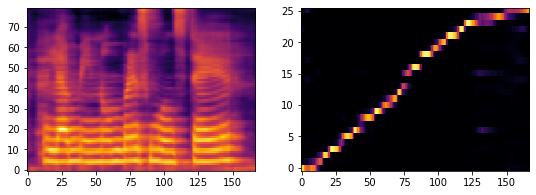

--------------------------------------------------
Stopping...


In [15]:
print("Enter/Paste your text.")
contents = []
while True:
    try:
        print("-"*50)
        line = input()
        if line == "":
            continue
        audio = end_to_end_infer(line, pronounciation_dictionary=False, show_graphs=True)
        display(ipd.Audio(audio, rate=sampling_rate))
    except EOFError:
        break
    except KeyboardInterrupt:
        print("Stopping...")
        break

In [10]:
vs = VoiceSynthetizer()

Removing weight norm...


In [11]:
vs.speak("Ya vivo en una clase.")